# Vancouver Crime - Clean
##### Author: Chad Neald
##### Date: October 4, 2024

### Objective

The objective of this notebook is to clean the downloaded Vancouver crime dataset.

In [1]:
import datetime
import re
from os import getcwd, path

import altair as alt
import ipywidgets as widgets
import pandas as pd
import pydeck as pdk
import utm
from IPython.display import display
from janitor import clean_names

In [2]:
alt.renderers.enable("mimetype");

### Check Working Directory

In [3]:
working_directory = getcwd()
directory_basename = path.basename(working_directory)

assert directory_basename == "vancouver_bike_thefts", "Incorrect working directory."

### Load in the Data

The raw data was downloaded from here: https://geodash.vpd.ca/opendata/#

In [4]:
raw_dir = path.join("data", "raw")

In [5]:
df = pd.read_csv(path.join(raw_dir, "crimedata_csv_AllNeighbourhoods_AllYears.csv"))

In [6]:
print(f"df length: {len(df)}")

df length: 895823


In [7]:
df.head(1)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Offence Against a Person,2020,7,31,0,0,OFFSET TO PROTECT PRIVACY,Kitsilano,0.0,0.0


### Clean the Column Names

In [8]:
df = clean_names(df)

In [9]:
df = df.rename(columns={"year": "date_year", "month": "date_month"})

### Remove Rows

Remove any rows without an explicit x and y location.

In [10]:
df.query("x == 0 and y == 0").type.value_counts()

type
Offence Against a Person                                80341
Homicide                                                  327
Vehicle Collision or Pedestrian Struck (with Injury)        3
Name: count, dtype: int64

In [11]:
df = df.query("x != 0 or y != 0")
len(df)

815152

In the data description file provided with the raw data, it states that incidents without a known location
were set to a default value of "X NK_LOC ST" for the HUNDRED_BLOCK column.

Let's exclude these data points since one of the goals of this project is to visualize where the 
incidents are occurring in the city. 
If an exact or rough location isn't known, then the data isn't very useful for this purpose.

In [12]:
df = df.query("hundred_block != 'X NK_LOC ST'")

Remove rows with a NaN value in either the X or the Y column.

In [13]:
df.isna().sum()

type              0
date_year         0
date_month        0
day               0
hour              0
minute            0
hundred_block    12
neighbourhood    43
x                29
y                29
dtype: int64

In [14]:
df = df.dropna(subset=["x", "y"]).reset_index(drop=True)

### Convert the X and Y Columns

The X and Y columns are in UTM Zone 10.
Let's convert these to latitude and longitude.

In [15]:
df["latitude"] = df.apply(
    lambda row: utm.to_latlon(row["x"], row["y"], 10, northern=True)[0], axis=1
)

df["longitude"] = df.apply(
    lambda row: utm.to_latlon(row["x"], row["y"], 10, northern=True)[1], axis=1
)

### Filter By Type - Theft of Bicycle

Let's filter the data to only include "Theft of Bicycle" incidents.
By keeping only these specific data points, the visualization will be less crowded
and more focused.

In [16]:
df.type.unique()

array(['Other Theft', 'Theft from Vehicle', 'Theft of Bicycle',
       'Theft of Vehicle',
       'Vehicle Collision or Pedestrian Struck (with Fatality)',
       'Vehicle Collision or Pedestrian Struck (with Injury)',
       'Break and Enter Commercial', 'Break and Enter Residential/Other',
       'Mischief'], dtype=object)

In [17]:
df_bicycle = df.query("type == 'Theft of Bicycle'").reset_index(drop=True)

In [18]:
len(df_bicycle)

37955

### Preliminary Visualization

In [19]:
df_bicycle.head(1)

,type,date_year,date_month,day,hour,minute,hundred_block,neighbourhood,x,y,latitude,longitude
0,Theft of Bicycle,2023,10,23,0,0,10XX ALBERNI ST,West End,491058.8169,5.459123e+06,49.284794,-123.122946


In [20]:
temp_df = df_bicycle.groupby("date_year").size().reset_index(name="number_of_incidents")
temp_df.head(1)

,date_year,number_of_incidents
0,2003,1409


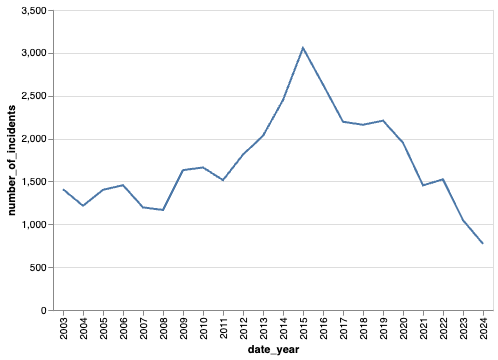

In [21]:
alt.Chart(temp_df).mark_line().encode(
    x=alt.X("date_year:O"), y=alt.Y("number_of_incidents")
)

### Export the Data

In [22]:
cleaned_dir = path.join("data", "cleaned")

# now = str(datetime.datetime.now()).replace(":", "-").replace(" ", "_").replace(".", "-")
# output_file = "vancouver_bicycle_thefts_cleaned_" + now + ".csv"

output_file = "vancouver_bicycle_thefts_cleaned.csv"

df_bicycle[["longitude", "latitude", "date_year"]].to_csv(
    path.join(cleaned_dir, output_file),
    index=False,
    encoding="utf-8-sig",
)